In [1]:
# For reading, visualizing, and preprocessing data
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
# from sklear.prepressing import Imputer
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [2]:
file = Path('wl/df_all.csv')
s_path = Path('Data/df_all_2019_2020.csv')
df_all_2019_2020 = pd.read_csv(file, parse_dates=True, infer_datetime_format=True)
df_all_2019_2020 = df_all_2019_2020.loc[(df_all_2019_2020['date'] >= '2010-08-31') & (df_all_2019_2020['date'] < '2020-03-01')]
df_all_2019_2020 = df_all_2019_2020.round(decimals=2)
df_all_2019_2020['change'] = df_all_2019_2020['price'].pct_change()
df_all_2019_2020 = df_all_2019_2020.dropna(subset=['change'])
df_all_2019_2020.head()


,date,price,uup,gdp,prod,vader,textblob_polarity,change
3045,2010-09-01,73.91,23.19,99.65,5562.00,0.26,-0.00,0.027670
3046,2010-09-02,75.02,23.17,99.65,5563.03,0.25,-0.01,0.015018
3047,2010-09-03,74.60,23.05,99.66,5564.07,0.25,-0.01,-0.005599
3048,2010-09-04,74.47,23.11,99.66,5565.10,0.24,-0.02,-0.001743
3049,2010-09-05,74.34,23.18,99.66,5566.13,0.23,-0.02,-0.001746


In [3]:
df_all_2019_2020.loc[df_all_2019_2020['change'] < 0, 'up/down'] = 0 
df_all_2019_2020.loc[df_all_2019_2020['change'] >= 0, 'up/down'] = 1
# df_all_2019_2020.loc[df_all_2019_2020['change'] == 0, 'up/down'] = 0
df_all_2019_2020.drop(columns=['price','change'], inplace=True)
df_all_2019_2020['up/down']= df_all_2019_2020['up/down'].astype(int)
df_all_2019_2020.head()

,date,uup,gdp,prod,vader,textblob_polarity,up/down
3045,2010-09-01,23.19,99.65,5562.00,0.26,-0.00,1
3046,2010-09-02,23.17,99.65,5563.03,0.25,-0.01,1
3047,2010-09-03,23.05,99.66,5564.07,0.25,-0.01,0
3048,2010-09-04,23.11,99.66,5565.10,0.24,-0.02,0
3049,2010-09-05,23.18,99.66,5566.13,0.23,-0.02,0


In [4]:
# Get data
# X, y = make_classification(n_samples = 1000, n_features = 30, n_informative = 5,
#                            n_redundant = 15, n_repeated = 5, 
#                            n_clusters_per_class = 2, class_sep = 0.5,
#                            random_state = 1000, shuffle = False)



# Numpy array to pandas dataframe
X = df_all_2019_2020.drop(columns = ['up/down', 'date'])
y = df_all_2019_2020['up/down']


In [5]:
X_min_max_scale=  pd.DataFrame(MinMaxScaler().fit_transform(X))

In [6]:
# X_min_max_scale.head()

In [7]:
columns = X.columns
X_min_max_scale.columns = columns
X_min_max_scale.head()

,uup,gdp,prod,vader,textblob_polarity
0,0.433681,0.798561,0.009982,0.629032,0.500
1,0.430700,0.798561,0.010117,0.623656,0.495
2,0.412817,0.800360,0.010253,0.623656,0.495
3,0.421759,0.800360,0.010389,0.618280,0.490
4,0.432191,0.800360,0.010524,0.612903,0.490


In [8]:
# creat train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)


In [9]:
# scaler = StandardScaler()
# X_scaler = scaler.fit(X_train)
# X_scaled = scaler.transform(X_scaler)

In [10]:
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [11]:
# Hyper-parameters
# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["eigen"], 
                                         }})    # switch from svd solver to eigen

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})  # this regs the per-class covariance estimates by transfroming S2 where
                                              # S2 corresponds to the scaling attribute of a given class
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1] # using all processors, 1 none running in parallel
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})



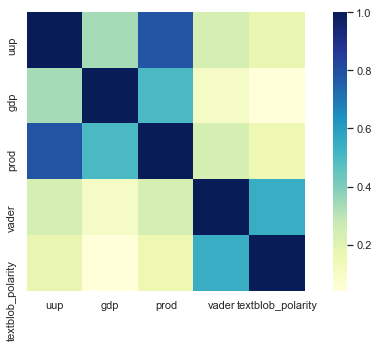

In [12]:
# Feature selction: remove highly correlated features
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

In [13]:
# # Tuning a classifer to use with RFECV

# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

# Tune classifier (Took = 4.8 minutes)
    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)

# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 2, n_jobs= -1, verbose = 1, scoring = "roc_auc")
# removed cv = 5 from original code
                  
# Fit gscv
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")

# gscv.fit(df_min_max_scale, np.ravel(y_train))
gscv.fit(X_train, y_train)

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)


Now tuning Random Forest. Go grab a beer or something.
Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  1.4min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features='sqrt', min_samples_leaf=0.005,
                       min_samples_split=0.01, n_estimators=200, n_jobs=-1)

In [14]:
# #Custom pipline object to use with RFECV
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self


In [15]:
# # Feature Selection: Recursive feature selction with cross validation
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 2, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, y_train)

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


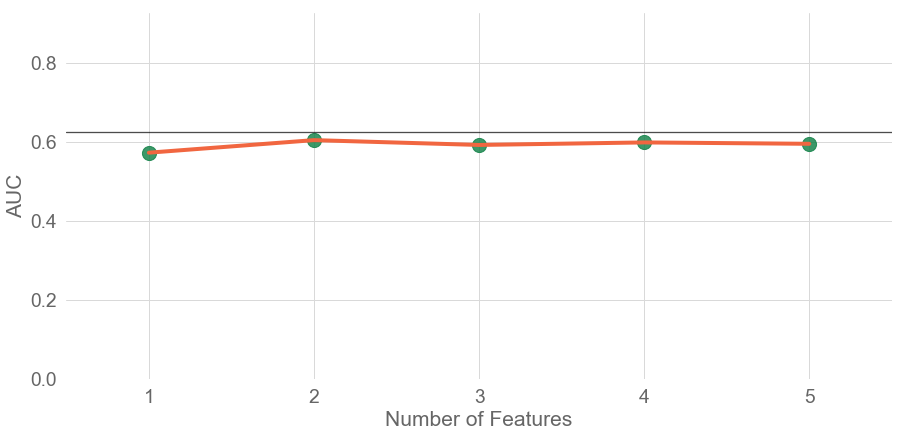

In [16]:
# # PERFORMANCE CURVE

# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.0, 0.925)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("dc_performance_curve.png", dpi = 1080)


In [17]:
# # FEATURE SELECTION: RECURSIVE FEATURE SELECTION

# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 5, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, y_train)

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

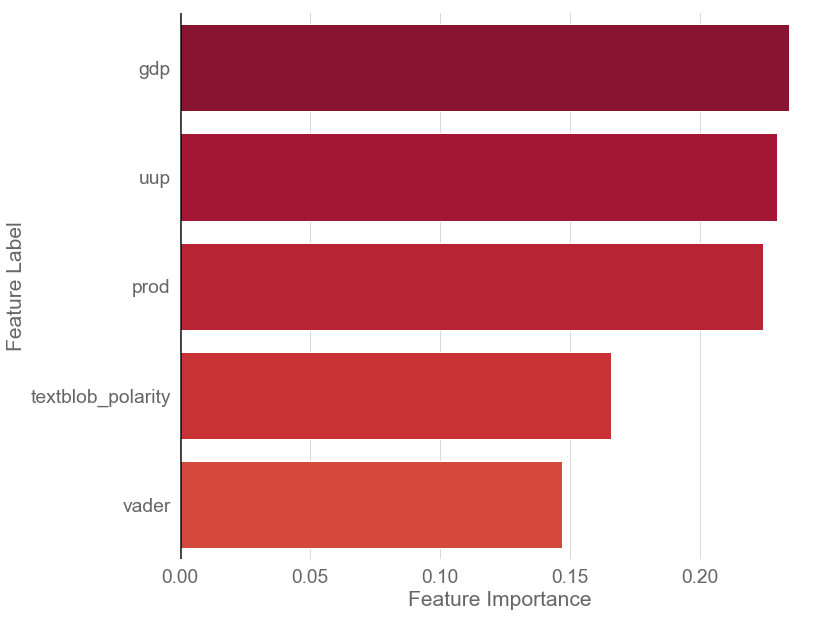

In [18]:
# # VUSUALIZING SELECTED FEATURE IMPORTANCE

# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("dc_feature_importance.png", dpi = 1080)


In [19]:
# # CLASSIFIER TUNING AND EVALUATION

# Initialize dictionary to store results
results = {}
crs = {}
# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 2,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, y_train)  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
    
    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    # Print Classification Report
    preds = gscv.predict(X_test)
    
    cr = {"Classifier": classifier_label,
              "Report": classification_report(y_test, preds, output_dict=True)}
    crs.update({classifier_label: cr})
    
    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc}
    
    results.update({classifier_label: result})

Now tuning LDA.
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Now tuning QDA.
Fitting 2 folds for each of 101 candidates, totalling 202 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Now tuning AdaBoost.
Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.8s finished


Now tuning Bagging.
Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.8s finished


Now tuning Extra Trees Ensemble.
Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
exception calling callback for <Future at 0x1f1b5733a88 state=finished raised PicklingError>
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\joblib\externals\loky\backend\queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "C:\Anaconda\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "C:\Anaconda\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "C:\Anaconda\lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 477, in dump
    return Pickler.dump(self, obj)
  File "C:\Anaconda\lib\pickle.py", line 437, in dump
    self.save(obj)
  File "C:\Anaconda\lib\pickle.py", line 549, in save
    self.save_reduce(obj=obj, *rv)
  File "C:\Anaconda\lib\p

KeyboardInterrupt: 

In [ ]:
# # VISUALING RESULTS

# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "AUC": [],
              "AUC Type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type", palette = colors,
            data=auc_scores)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("AUC Scores.png", dpi = 1080)

In [ ]:
df_auc = auc_scores.loc[(auc_scores['AUC Type']) == 'Test']
df_auc = df_auc.nlargest(3, 'AUC')
df_auc.style

In [ ]:
results["Gradient Boosting"]['Best Parameters']

In [ ]:
results["AdaBoost"]['Best Parameters']

In [ ]:
results["Random Forest"]['Best Parameters']

In [ ]:
print(results)

In [ ]:
df = pd.DataFrame(crs['Gradient Boosting']['Report']).transpose()
df.head()